<a href="https://colab.research.google.com/github/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/blob/main/Epileptic_Seizure_Prediction_using_EEG_bonn_data_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [2]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch.optim import Adam, SGD

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers


## Reading Data

In [4]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [5]:
raw_data.shape

(11500, 180)

In [6]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [15]:
data = raw_data.values
data = data[0:11501, 1:180]
data.shape

(11500, 179)

In [16]:
type(data)

numpy.ndarray

## Classifying data categories

In [17]:
D = data
df_1 = D[D[:, 178] == 1]
df_2 = D[D[:, 178] == 2]
df_3 = D[D[:, 178] == 3]
df_4 = D[D[:, 178] == 4]
df_5 = D[D[:, 178] == 5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Experiment 1: Comparing CNN and BiLSTM on Epilepsy versus Healthy Data Categories

In [18]:
df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

In [21]:
D1.shape

(4600, 179)

### Creating training (80), validation(10) and test(10) data from category 1 and 3


In [20]:
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)

label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(3680,) (3680, 178, 1)
(460,) (460, 178, 1)
(460,) (460, 178, 1)


### Define model evaluation function

In [23]:
def evaluate_model(history, X_test, y_test, model):
  scores = model.evaluate((X_test), y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  print(history)
  fig1, ax_acc = plt.subplots()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model - Accuracy')
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show()

  fig2, ax_loss = plt.subplots()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model - Loss')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.show()
  target_names = ['1', '2', '3']

  y_true = []
  for element in y_test:
    y_true.append(np.argmax(element))

  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba, axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)

### Define CNN network

In [24]:
def network_CNN(X_train, y_train):
  im_shape = (X_train.shape[1], 1)
  inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')

  conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
  batch_normalization = BatchNormalization()(conv1d_1)
  max_pooling1d = layers.MaxPooling1D(2, padding='same')(batch_normalization)

  conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
  batch_normalization_1 = BatchNormalization()(conv1d_2)
  max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)

  flatten = Flatten()(max_pooling1d_1)

  dense = Dense(32)(flatten)
  dense_1 = Dense(16)(dense)

  main_output = Dense(2)(dense_1)

  model1 = Model(inputs = inputs_cnn, outputs=main_output)
  model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model1


In [25]:
## Define CNN model to be trained on epileptic vs healthy data
model1 = network_CNN(data_train, label_train)
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 32)           224       
                                                                 
 batch_normalization (BatchN  (None, 173, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 87, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 85, 64)           256   

In [26]:
from sqlalchemy.sql.expression import true
## Train CNN network on epileptic vs healthy data
# Save model at highest validation accuracy
save_path = 'checkpoint_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history = model1.fit(data_train, label_train, epochs=500, batch_size=32, validation_data=(data_val, label_val), callbacks=[model_checkpoint_callback])

Epoch 1/500
115/115 [==============================] - 7s 31ms/step - loss: 0.8628 - accuracy: 0.8576 - val_loss: 1.0866 - val_accuracy: 0.6435
Epoch 2/500
115/115 [==============================] - 2s 18ms/step - loss: 0.6738 - accuracy: 0.7345 - val_loss: 0.6042 - val_accuracy: 0.7152
Epoch 3/500
115/115 [==============================] - 2s 18ms/step - loss: 0.6736 - accuracy: 0.7853 - val_loss: 0.6434 - val_accuracy: 0.8065
Epoch 4/500
115/115 [==============================] - 2s 18ms/step - loss: 0.6496 - accuracy: 0.8168 - val_loss: 0.6449 - val_accuracy: 0.8109
Epoch 5/500
115/115 [==============================] - 2s 18ms/step - loss: 0.6609 - accuracy: 0.7783 - val_loss: 0.6540 - val_accuracy: 0.7457
Epoch 6/500
115/115 [==============================] - 3s 23ms/step - loss: 0.6669 - accuracy: 0.7717 - val_loss: 0.6881 - val_accuracy: 0.8348
Epoch 7/500
115/115 [==============================] - 3s 22ms/step - loss: 0.7112 - accuracy: 0.8231 - val_loss: 0.6901 - val_accuracy:

Accuracy: 36.09%


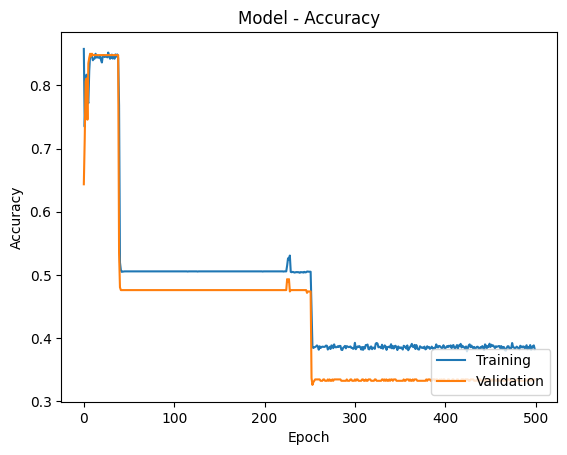

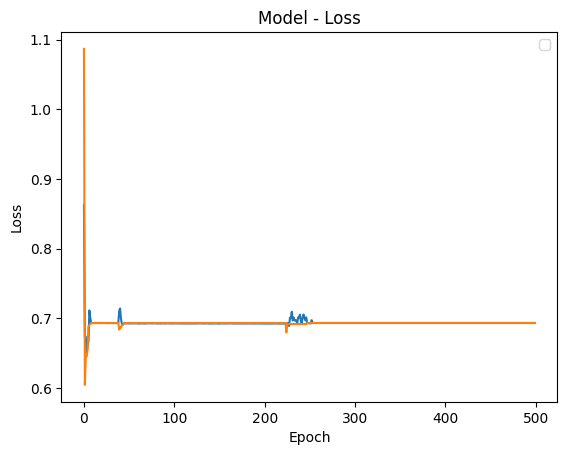

15/15 [==============================] - 0s 8ms/step


In [27]:
# print validation accuracy and plot accuracy and loss
evaluate_model(history, data_test, label_test, model1)
y_pred = model1.predict(data_test)

## Defining Bidirectional LSTM model

In [28]:
def network_LSTM(X_train, y_train):
  im_shape = (X_train.shape[1], 1)
  inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')

  dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
  lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
  dropout = Dropout(0.3)(lstm)
  batch_normalization = BatchNormalization(name='batch_normalization')(dropout)

  dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
  dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
  batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
  main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

  model = Model(inputs=inputs_lstm, outputs=main_output)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

  

In [29]:
model2 = network_LSTM(data_train, label_train)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [ ]:
# Train BiLSTM on epileptic vs healthy data
save_path = 'checkpoint_2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weight_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

history2 = model2.fit(data_train, label_train, epochs=100, batch_size=32, validation_data=(data_val, label_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.8997

115/115 [==============================] - 99s 815ms/step - loss: 0.2617 - accuracy: 0.8997 - val_loss: 0.1593 - val_accuracy: 0.9391
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9394

115/115 [==============================] - 79s 689ms/step - loss: 0.1680 - accuracy: 0.9394 - val_loss: 0.1172 - val_accuracy: 0.9609
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9454

115/115 [==============================] - 71s 622ms/step - loss: 0.1538 - accuracy: 0.9454 - val_loss: 0.0721 - val_accuracy: 0.9717
Epoch 4/100
115/115 [==============================] - 53s 460ms/step - loss: 0.1344 - accuracy: 0.9538 - val_loss: 0.0678 - val_accuracy: 0.9717
Epoch 5/100
115/115 [==============================] - 53s 459ms/step - loss: 0.1244 - accuracy: 0.9549 - val_loss: 0.0816 - val_accuracy: 0.9696
Epoch 6/100
115/115 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9595

115/115 [==============================] - 69s 601ms/step - loss: 0.1149 - accuracy: 0.9595 - val_loss: 0.0767 - val_accuracy: 0.9761
Epoch 7/100
115/115 [==============================] - 52s 457ms/step - loss: 0.1119 - accuracy: 0.9620 - val_loss: 0.0797 - val_accuracy: 0.9761
Epoch 8/100
115/115 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9595

115/115 [==============================] - 69s 600ms/step - loss: 0.1097 - accuracy: 0.9595 - val_loss: 0.0483 - val_accuracy: 0.9826
Epoch 9/100
115/115 [==============================] - 53s 458ms/step - loss: 0.1082 - accuracy: 0.9658 - val_loss: 0.0589 - val_accuracy: 0.9761
Epoch 10/100
115/115 [==============================] - 52s 451ms/step - loss: 0.0991 - accuracy: 0.9658 - val_loss: 0.0676 - val_accuracy: 0.9783
Epoch 11/100
115/115 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9647

115/115 [==============================] - 68s 592ms/step - loss: 0.0975 - accuracy: 0.9647 - val_loss: 0.0581 - val_accuracy: 0.9891
Epoch 12/100
115/115 [==============================] - 52s 454ms/step - loss: 0.1046 - accuracy: 0.9647 - val_loss: 0.0667 - val_accuracy: 0.9761
Epoch 13/100
115/115 [==============================] - 53s 464ms/step - loss: 0.1064 - accuracy: 0.9644 - val_loss: 0.0708 - val_accuracy: 0.9804
Epoch 14/100
115/115 [==============================] - 53s 465ms/step - loss: 0.1088 - accuracy: 0.9649 - val_loss: 0.0654 - val_accuracy: 0.9804
Epoch 15/100
115/115 [==============================] - 53s 459ms/step - loss: 0.0915 - accuracy: 0.9685 - val_loss: 0.0634 - val_accuracy: 0.9804
Epoch 16/100
115/115 [==============================] - 52s 455ms/step - loss: 0.0820 - accuracy: 0.9731 - val_loss: 0.0565 - val_accuracy: 0.9826
Epoch 17/100
115/115 [==============================] - 53s 462ms/step - loss: 0.0895 - accuracy: 0.9720 - val_loss: 0.0783 - val_a

In [ ]:
evaluate_model(history2, data_test, label_test, model2)

In [ ]:
model2.load_weights(save_path)
evaluate_model(history2, data_test, label_test, model2)